## Keyword Extraction with BERT

With methods such as Rake and YAKE! we already have easy-to-use packages that can be used to extract keywords and keyphrases. However these models typically work based on the statistical properties of a text and not so much on semantic similarity.

In comes BERT. BERT is a bi-directional transformer model that allows us to transform phrases and documents to vectors that capture their meaning.

Although there are many great papers and solutions out there that use BERT-embeddings, I could not find a simple and easy-to-use BERT-based solution. Instead, I decide to create KeyBERT a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings.

KeyBERT is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to create keywords and keyphrases that are most similar to a document. This is a tutorial on how to use BERT to create your own keyword extraction model.

1. First, document embeddings are extracted with BERT to get a document-level representation.

2. Then, word embeddings are extracted for N-gram words/phrases.

3. Finally, we use cosine similarity to find the words/phrases that are the most similar to the document. The most similar words could then be identified as the words that best describe the entire document.

## Theory 

### 1. Data

For this tutorial, we are going to be using a document about supervised machine learning:

In [1]:
doc = """
         Supervised learning is the machine learning task of 
         learning a function that maps an input to an output based 
         on example input-output pairs.[1] It infers a function 
         from labeled training data consisting of a set of 
         training examples.[2] In supervised learning, each 
         example is a pair consisting of an input object 
         (typically a vector) and a desired output value (also 
         called the supervisory signal). A supervised learning 
         algorithm analyzes the training data and produces an 
         inferred function, which can be used for mapping new 
         examples. An optimal scenario will allow for the algorithm 
         to correctly determine the class labels for unseen 
         instances. This requires the learning algorithm to  
         generalize from the training data to unseen situations 
         in a 'reasonable' way (see inductive bias).
      """

I believe that using a document about a topic that the readers know quite a bit about helps you understand if the resulting keyphrases are of quality.

### 2. Candidate Keywords/Keyphrases

We start by creating a list of candidate keywords or keyphrases from a document. Although many focus on noun phrases, we are going to keep it simple by using Scikit-Learns `CountVectorizer`. This allows us to specify the length of the keywords and make them into keyphrases. It also is a nice method for quickly removing stop words.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (3, 3)  #(3,3)
stop_words = 'english'

# Extract candicate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
candidates = count.get_feature_names()

In [21]:
len(candidates) #72

72

We can use `n_gram_range` to change the size of the resulting candidates. For example, if we would set it to (3, 3) then the resulting candidates would phrases that include 3 keywords.

Then, the variable `candidates` is simply a list of strings that includes our candidate keywords/keyphrases.

**NOTE**: You can play around with `n_gram_range` to create different lengths of keyphrases. Then, you might not want to remove stop_words as they can tie(扎，绑，系) longer keyphrases together.

### 3. Embeddings

Next, we convert both the document as well as the candidate keywords/keyphrases to numerical data. We use **BERT** for this purpose as it has shown great results for both similarity- and paraphrasing(释义) tasks.

There are many methods for generating the BERT embeddings, such as Flair, Hugginface Transformers, and now even spaCy with their 3.0 release! However, I prefer to use the `sentence-transformers` package as it allows me to quickly create high-quality embeddings that work quite well for sentence- and document-level embeddings.

We install the package with `pip install sentence-transformers`. If you run into issues installing this package, then it might be helpful to install Pytorch first.

Now, we are going to run the following code to transform our document and candidates into vectors:

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

In [23]:
candidate_embeddings.shape #(72, 768)

(72, 768)

We are **Distilbert** as it has shown great performance in similarity tasks, which is what we are aiming for with keyword/keyphrase extraction!

Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting up your document into paragraphs and mean pooling (taking the average of) the resulting vectors.

**NOTE**: There are many pre-trained BERT-based models(https://github.com/UKPLab/sentence-transformers) that you can use for keyword extraction. However, I would advise you to use either `distilbert — base-nli-stsb-mean-tokens` or `xlm-r-distilroberta-base-paraphase-v1` as they have shown great performance in **semantic similarity** and **paraphrase identification** respectively.

### 4. Cosine Similarity

In the final step, we want to find the candidates that are most similar to the document. We assume that the most similar candidates to the document are good keywords/keyphrases for representing the document.

To calculate the similarity between candidates and the document, we will be using the cosine similarity between vectors as it performs quite well in high-dimensionality:

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = 5
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [19]:
keywords

['mapping', 'class', 'training', 'algorithm', 'learning']

Now, let us take a look at what happens if we change the `n_gram_range` to (3,3)

In [25]:
keywords

['algorithm analyzes training',
 'learning algorithm generalize',
 'learning machine learning',
 'learning algorithm analyzes',
 'algorithm generalize training']

It seems that we get keyphrases instead of keywords now! These keyphrases, by themselves, seem to nicely represent the document. However, I am not happy that all keyphrases are so similar to each other.

To solve this issue, let us take a look at the **diversification(多样化)** of our results.

### 5. Diversification

There is a reason why similar results are returned… they best represent the document! If we were to diversify(多样化) the keywords/keyphrases then they are less likely to represent the document well as a collective(集体).

Thus, the diversification of our results requires a delicate(巧妙的精美的) balance between the accuracy of keywords/keyphrases and the diversity between them.

There are two algorithms that we will be using to diversify our results:

- **max Sum Similarity**

- **Maximal Marginal Relevance(最大边际相关性)**

#### Max Sum Similarity

The maximum sum distance between pairs of data is defined as the pairs of data for which the distance between them is maximized. In our case, we want to maximize the candidate similarity to the document whilst(同时) minimizing the similarity between candidates.

To do this, we select the top 20 keywords/keyphrases, and from those 20, select the 5 that are the least similar to each other:

In [26]:
import numpy as np
import itertools

def max_sum_sim(doc_embedding, word_embeddings, words, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings, candidate_embeddings)
    
    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]
    
    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)),top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i!=j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim
            
    return [words_vals[idx] for idx in candidate]

If you set a low `nr_candidates`, then our results seem to be very similar to our original cosine similarity method:

In [29]:
keywords

['algorithm analyzes training',
 'learning algorithm generalize',
 'learning machine learning',
 'learning algorithm analyzes',
 'algorithm generalize training']

In [27]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=5, nr_candidates=10)

['requires learning algorithm',
 'signal supervised learning',
 'learning function maps',
 'algorithm analyzes training',
 'learning machine learning']

However, a relatively high `nr_candidates` will create more diverse keyphrases:

In [30]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=5, nr_candidates=20)

['set training examples',
 'generalize training data',
 'requires learning algorithm',
 'supervised learning algorithm',
 'learning machine learning']

As mentioned before, there is a tradeoff between accuracy and diversity that you must keep in mind. If you increase the `nr_candidates`, then there is a good chance you get very diverse keywords but that are not very good representations of the document.

I would advise you to keep `nr_candidates` less than 20% of the total number of unique words in your document.

#### Maximal Marginal Relevance

The final method for diversifying our results is **Maximal Marginal Relevance (MMR)**. MMR tries to minimize redundancy and maximize the diversity of results in text summarization tasks. Fortunately, a keyword extraction algorithm called **EmbedRank**(https://arxiv.org/pdf/1801.04470.pdf) has implemented a version of MMR that allows us to use it for diversifying our keywords/keyphrases.

We start by selecting the keyword/keyphrase that is the most similar to the document. Then, we iteratively select new candidates that are both similar to the document and not similar to the already selected keywords/keyphrases:

In [31]:
import numpy as np

def mmr(doc_embedding, word_embeddings, words, top_n, diversity):
    
    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)
    
    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]
    
    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

If we set a relatively **low diversity**, then our results seem to be very similar to our original cosine similarity method:

In [32]:
keywords

['algorithm analyzes training',
 'learning algorithm generalize',
 'learning machine learning',
 'learning algorithm analyzes',
 'algorithm generalize training']

In [33]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=5, diversity=0.2)

['algorithm generalize training',
 'supervised learning algorithm',
 'learning machine learning',
 'learning algorithm analyzes',
 'learning algorithm generalize']

However, a relatively **high diversity** score will create very diverse keyphrases:

In [34]:
keywords

['algorithm analyzes training',
 'learning algorithm generalize',
 'learning machine learning',
 'learning algorithm analyzes',
 'algorithm generalize training']

In [35]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=5, diversity=0.7)

['algorithm generalize training',
 'labels unseen instances',
 'new examples optimal',
 'determine class labels',
 'supervised learning algorithm']

## Practice

### 1. Installation

`pip install keybert`

### 2.KeyBERT 参数 Model

`_init__(self, model='paraphrase-MiniLM-L6-v2')`

KeyBERT 的参数只有一个，即训练好的模型，是自定义嵌入模型。KeyBERT 0.4.0 包中默认的model是paraphrase-MiniLM-L6-v2, 支持：

- Sentence Transformer    
- Flair     
- Spacy      
- Gensim     
- USE(TF-Hub)

其中，SentenceTransformers包含了一系列模型，具体可参考Pretrain Models(https://www.sbert.net/docs/pretrained_models.html)

### 3. SentenceTransformers模型调用

模型的使用方法很简单：

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('model_name')

### 4. SentenceTransformers模型展示

NOTE: For a full overview of all possible transformer models see sentence-transformer. I would advise either `all-MiniLM-L6-v2` for English documents or `paraphrase-multilingual-MiniLM-L12-v2` for multi-lingual documents or any other language.

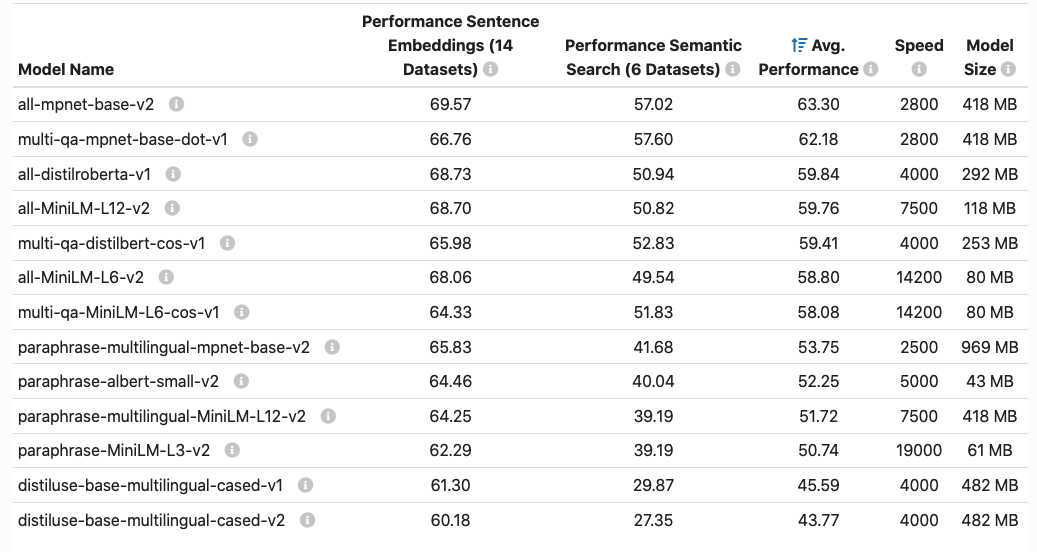

### 5. Flair模型调用

[Flair](https://github.com/flairNLP/flair) allows you to choose almost any embedding model that is publicly available. Flair can be used as follows:

Flair 的使用方式如下

In [ ]:
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings

roberta = TransformerDocumentEmbeddings('roberta-base')
kw_model = KeyBERT(model=roberta)

### 6. extract_keywords参数介绍

```
extract_keywords(self,
                 docs: Union[str, List[str]],
                 candidates: List[str] = None,
                 keyphrase_ngram_range: Tuple[int, int] = (1, 1),
                 stop_words: Union[str, List[str]] = 'english',
                 top_n: int = 5,
                 min_df: int = 1,
                 use_maxsum: bool = False,
                 use_mmr: bool = False,
                 diversity: float = 0.5,
                 nr_candidates: int = 20,
                 vectorizer: CountVectorizer = None,
                 highlight: bool = False)
```
**Note:**

建议迭代单个文档，即使速度较慢，但他们需要最少的内存，不太可能遇到内存错误。

多个文件：

有一个选项可以为多个文档提取关键字，这比提取多个单个文档要快。但这种方法假设你可以将词汇表中的所有单词的词嵌入保留在内存中，可能比较麻烦。当你的硬件有限，建议不要使用此选项并简单地迭代文档。

**参数：**

- docs: 待提取关键字/关键短语的文档

- candidates:要使用的候选关键词/关键短语，不是从文档中提取他们

- keyphrase_ngram_range: 提取的关键词/关键短语的长度(以字为单位)

- stop_words: 要从文档中删除的停用词

- top_n: 返回前n个关键字/关键短语

- min_df: 如果需要提取多个文档的关键字，则一个单词在所有文档中的最小文档频率

- use_maxsum: 是否使用 Max Sum Similarity 来选择 keywords/keyphrases

- use_mmr: 是否使用最大边界相关性(MMR)进行 keywords/keyphrases的选择

- diversity: 如果use_mmr为True, 结果的多样性在[0,1]之间

- nr_candidates: 如果 use_maxsum 设置为True,要考虑候选数

- vectorizer: 从 scikit-learn 传入自己的 CountVectorizer

- highlight: 是否打印文档并突出显示 keywords/keyphrases. Note: 如果传入多个文档，则不起作用

**Return**:

keywords: 文档的前n个关键字及其各自到输入文件的距离

### 7. Usage

The most minimal example can be seen below for the extraction of keywords:

In [2]:
from keybert import KeyBERT

doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """
kw_model = KeyBERT(model='paraphrase-MiniLM-L6-v2')
print('naive...')
keywords = kw_model.extract_keywords(doc)
print(keywords)

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.